## <u>*Classsification Modelling for gender as a Target Feature*</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os
import json

In [2]:
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRFClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials

---

*Importing Data :*

In [3]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm","numclaims"],axis=1)
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.06,0.303901,0.0,HBACK,3,F,C,2
1,1.03,0.648871,0.0,HBACK,2,F,A,4
2,3.26,0.569473,0.0,UTE,2,F,E,2
3,4.14,0.317591,0.0,STNWG,2,F,D,2
4,0.72,0.648871,0.0,HBACK,4,F,C,2


---

*Sorting Data :*

In [4]:
df=df.sort_values(by=['veh_age', 'agecat','area','gender']).reset_index().drop("index",axis=1)
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.59,0.229979,0.0,SEDAN,1,F,A,1
1,1.46,0.221766,0.0,HBACK,1,F,A,1
2,1.54,0.238193,0.0,SEDAN,1,F,A,1
3,1.57,0.522930,0.0,SEDAN,1,F,A,1
4,1.41,0.219028,0.0,HBACK,1,F,A,1


---

*Data Shape :*

In [5]:
df.shape

(67856, 8)

---

*Define categorical features and numerical features :*

In [6]:
categorical_features=df.select_dtypes(include=["object"])
numerical_features=df.select_dtypes(exclude=["object"])

print("we have {} numerical features : {}\n".format(numerical_features.shape[1],list(numerical_features.columns)))
print("we have {} categorical features : {}".format(categorical_features.shape[1],list(categorical_features.columns)))

we have 3 numerical features : ['veh_value', 'exposure', 'claimcst0']

we have 5 categorical features : ['veh_body', 'veh_age', 'gender', 'area', 'agecat']


---

*Categorical features Frequency percenatge :*

In [7]:
for col in categorical_features:
    print(df[col].value_counts(normalize=True)*100)

veh_body
SEDAN    32.764973
HBACK    27.875206
STNWG    23.963983
UTE       6.758430
TRUCK     2.578991
HDTOP     2.326987
COUPE     1.149493
PANVN     1.108229
MIBUS     1.056649
MCARA     0.187161
CONVT     0.119370
BUS       0.070738
RDSTR     0.039790
Name: proportion, dtype: float64
veh_age
3    29.568498
4    27.923839
2    24.444412
1    18.063252
Name: proportion, dtype: float64
gender
F    56.88959
M    43.11041
Name: proportion, dtype: float64
area
C    30.269983
A    24.039142
B    19.660752
D    12.044624
E     8.712568
F     5.272931
Name: proportion, dtype: float64
agecat
4    23.857876
3    23.235970
2    18.974004
5    15.821740
6     9.648373
1     8.462037
Name: proportion, dtype: float64


---

In [35]:
### *Univariant analysis*

*Visualizing numerical features :*

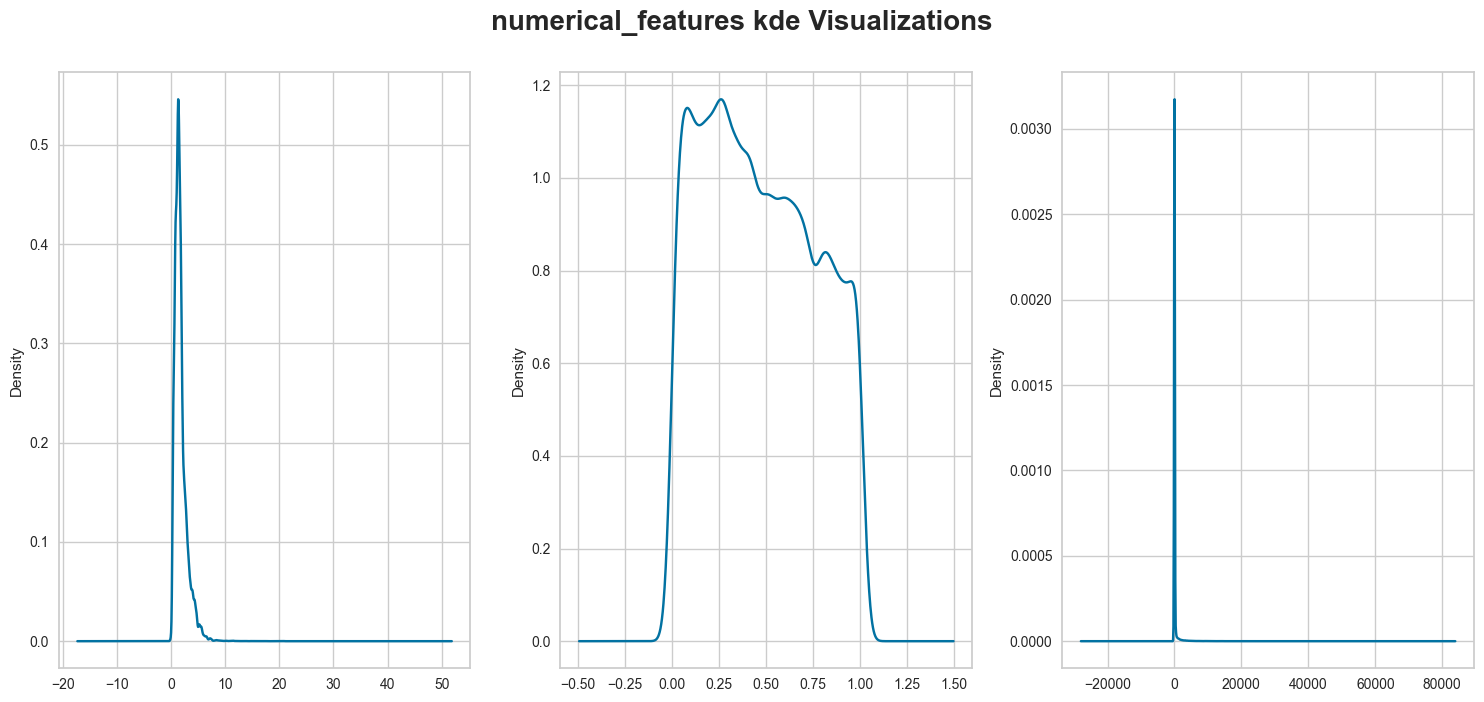

In [8]:
def plot_numerical_features(numerical_features,ChartType):
    nrows = 1
    ncols = 3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7))
    fig.suptitle(f"numerical_features {ChartType} Visualizations",fontsize=20,fontweight="bold",y=1.)
    
    axes = axes.flatten()

    for i, column in enumerate(numerical_features.columns):
        if i >= nrows * ncols:
            break 
        numerical_features[column].plot(ax=axes[i], kind=f"{ChartType}")
        plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/generalGraphs/plot_numerical_features.png',dpi=500);
        


    plt.tight_layout()
    plt.show()

plot_numerical_features(numerical_features[["veh_value","exposure","claimcst0"]],"kde")


---

*Visualizing categorical features :*

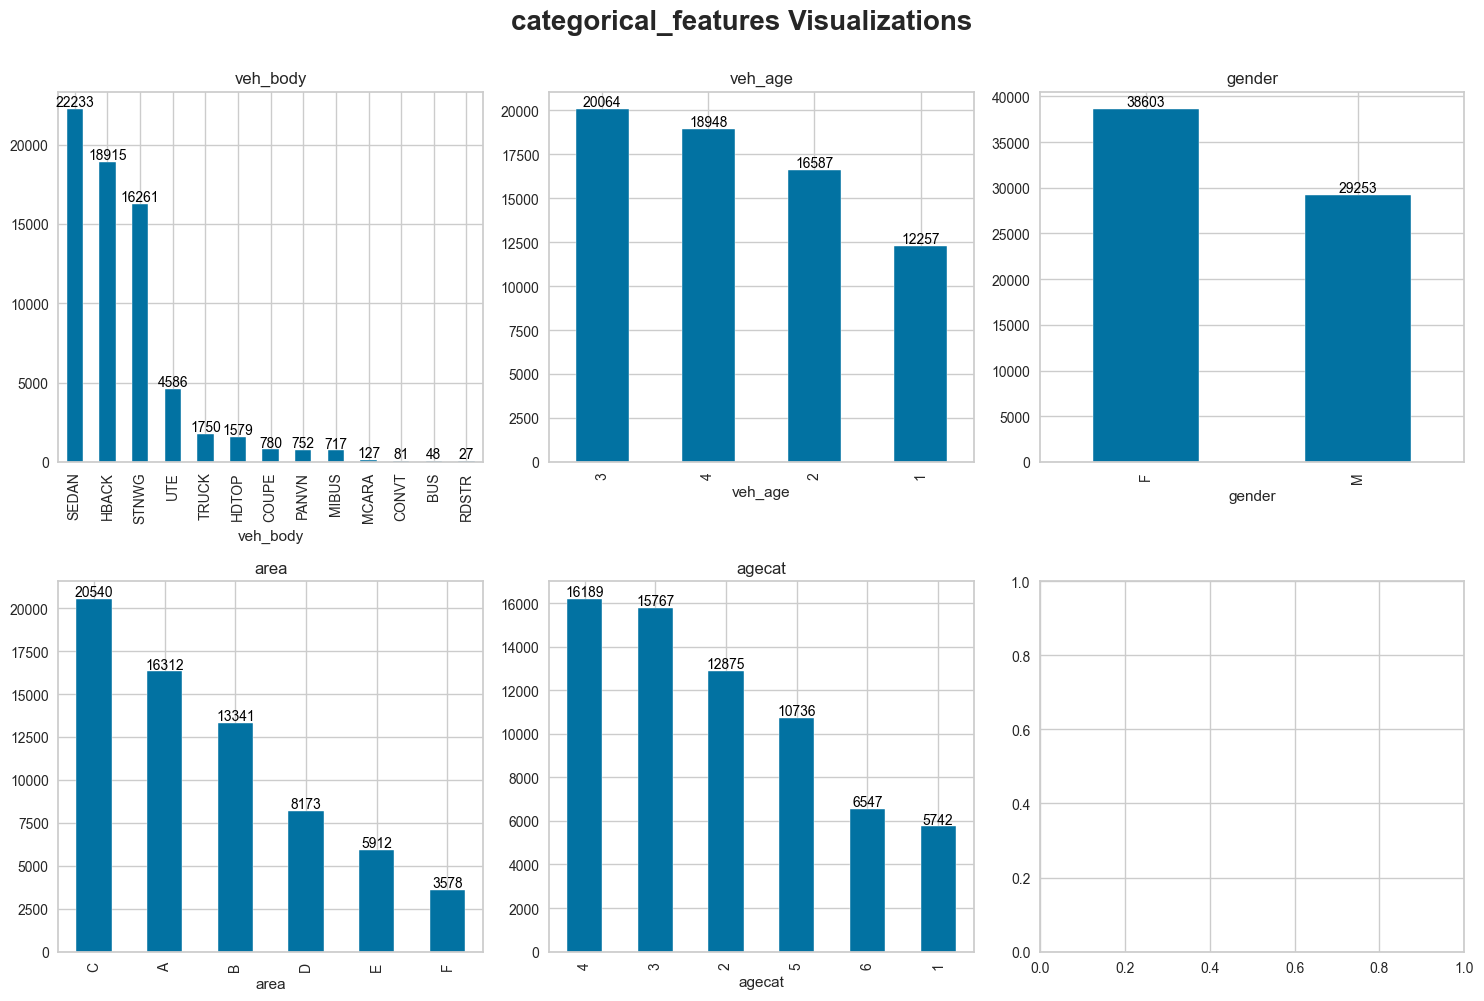

In [9]:
def plot_categorical_features(categorical_features):
    nrows = 2
    ncols = 3
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    fig.suptitle(f"categorical_features Visualizations",fontsize=20,fontweight="bold",y=1.)

    axes = axes.flatten()
    
    for i, column in enumerate(categorical_features.columns):
        if i >= nrows * ncols:
            break 
        ax = axes[i]
        counts = categorical_features[column].value_counts()
        counts.plot(kind='bar', ax=ax, title=column)
        
        for bar in ax.patches:
            ax.annotate(
                str(bar.get_height()),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points'
            )
        plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/generalGraphs/plot_categorical_features.png',dpi=500);
        
    plt.tight_layout()
    plt.show()

plot_categorical_features(categorical_features)    

---

*Define discretes feature and countinuous features :*

In [10]:
discrete_feature=[feature for feature in numerical_features if  len(df[feature].unique())<=25]
countinuous_feature=[feature for feature in numerical_features if  len(df[feature].unique())>25]

In [11]:

print("we have {} discrete feature : {}\n".format(len(discrete_feature),(discrete_feature)))
print("we have {} countinuous feature : {}".format(len(countinuous_feature),(countinuous_feature)))

we have 0 discrete feature : []

we have 3 countinuous feature : ['veh_value', 'exposure', 'claimcst0']


---

*Categorical features Frequency percenatge by gender :*

In [12]:
df.groupby("gender")["area"].value_counts(normalize=True).to_frame()*100

proportion
gender area            
F      C      30.601249
       A      24.052535
       B      19.793798
       D      12.271067
       E       8.473435
       F       4.807916
M      C      29.832838
       A      24.021468
       B      19.485181
       D      11.745804
       E       9.028134
       F       5.886576

* *Insights :*

*1. Area C has the highest Proportion between genders*

*2. Area F has the lowest Proportion between genders*

In [13]:
df.groupby("agecat")["area"].value_counts(normalize=True).to_frame()*100

proportion
agecat area            
1      C      31.173807
       A      24.155347
       B      18.164403
       D      11.529084
       E       8.045977
       F       6.931383
2      C      29.568932
       A      23.200000
       B      19.673786
       D      10.679612
       F       8.559223
       E       8.318447
3      C      28.914822
       A      23.086193
       B      20.162364
       D      12.253441
       E       9.272531
       F       6.310649
4      C      31.780839
       A      24.646365
       B      19.185867
       D      11.668417
       E       8.332819
       F       4.385694
5      C      30.840164
       A      24.152385
       B      20.650149
       D      12.788748
       E       8.671759
       F       2.896796
6      C      29.448602
       A      26.195204
       B      19.291278
       D      14.388269
       E       9.729647
       F       0.946999

* *Insights :*

*1. Area C has the highest Proportion among  all age categories*

*2. Area F has the lowest Proportion among  all age categories except age categorty 2 where Area E has the lowest*

In [14]:
df.groupby("veh_age")["area"].value_counts(normalize=True).to_frame()*100

proportion
veh_age area            
1       C      29.591254
        A      24.851105
        B      19.221669
        D      12.319491
        E       8.974464
        F       5.042017
2       C      31.253391
        A      25.049738
        B      20.081992
        D      10.809670
        E       7.945982
        F       4.859227
3       C      29.804625
        A      23.933413
        B      19.078947
        D      12.295654
        E       9.130781
        F       5.756579
4       C      30.340933
        A      22.741186
        B      20.192105
        D      12.682077
        E       8.771374
        F       5.272324

* *Insights :*

*1. Area C has the highest Proportion among  all veh age categories*

*2. Area F has the lowest Proportion among  all veh age categories*

In [15]:
df.groupby("veh_body")["area"].value_counts(normalize=True).to_frame()*100

proportion
veh_body area            
BUS      C      25.000000
         E      18.750000
         F      18.750000
         A      12.500000
         B      12.500000
...                   ...
UTE      D      18.316616
         E      16.463149
         B      16.354121
         A      15.438290
         F      10.968164

[76 rows x 1 columns]

* *Insights :*

*A. :*

---

*Visualizing Categorical and numerical features by gender :*

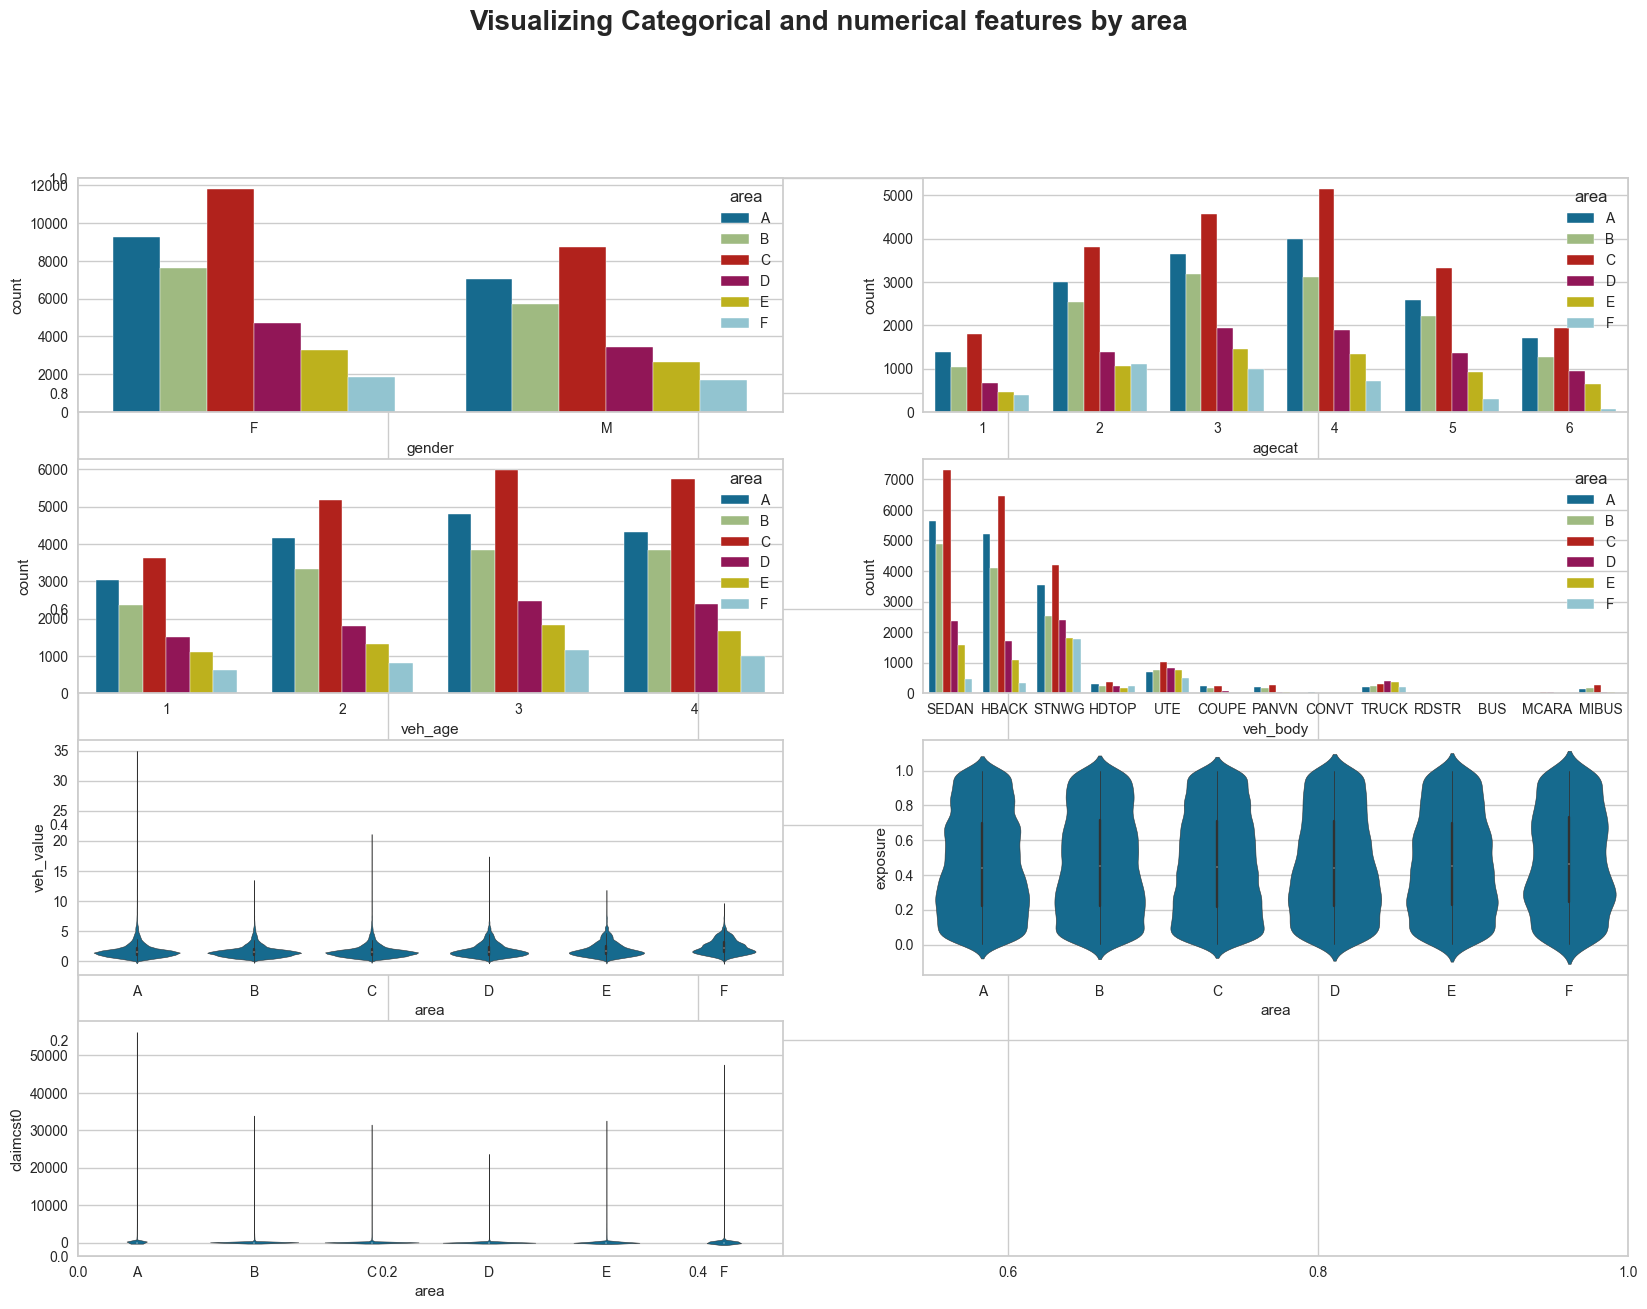

In [16]:
plt.subplots(figsize=(20,14))
plt.suptitle(f"Visualizing Categorical and numerical features by area",fontsize=20,fontweight="bold",y=1.)
plt.subplot(421)
sns.countplot(x="gender",hue="area",data=df)
plt.subplot(422)
sns.countplot(x="agecat",hue="area",data=df)
plt.subplot(423)
sns.countplot(x="veh_age",hue="area",data=df)
plt.subplot(424)
sns.countplot(x="veh_body",hue="area",data=df)
plt.subplot(425)
sns.violinplot(x="area",y="veh_value",data=df)
plt.subplot(426)
sns.violinplot(x="area",y="exposure",data=df)
plt.subplot(427)
sns.violinplot(x="area",y="claimcst0",data=df)
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresbytargetGraphs/plot_features_by_area.png',dpi=500);


---

In [17]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

*Define x and y*

In [18]:
x=df.drop("area",axis=1)
y=df["area"]

---

*Countinuous features Skewbess -outliers-*

In [19]:
x[countinuous_feature].skew(axis=0,skipna=True)

veh_value     2.968022
exposure      0.175557
claimcst0    17.502503
dtype: float64

---

*Transforming countinuous features to handle the outliers*

In [20]:
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method="yeo-johnson")
transform_features=['veh_value', 'claimcst0']
x_copy=pt.fit_transform(x[transform_features])

In [21]:
x_copy=pd.DataFrame(x_copy,columns=transform_features)
x_copy

,veh_value,claimcst0
0,0.103702,-0.270421
1,-0.043000,-0.270421
2,0.048639,-0.270421
3,0.081874,-0.270421
4,-0.102624,-0.270421
...,...,...
67851,-0.446192,-0.270421
67852,0.229457,-0.270421
67853,-2.565485,-0.270421
67854,-0.877562,-0.270421


In [22]:
x_copy.skew(axis=0,skipna=True)

veh_value    0.010369
claimcst0    3.427592
dtype: float64

---

*Visualizing  countinuous features after tranformation  :*

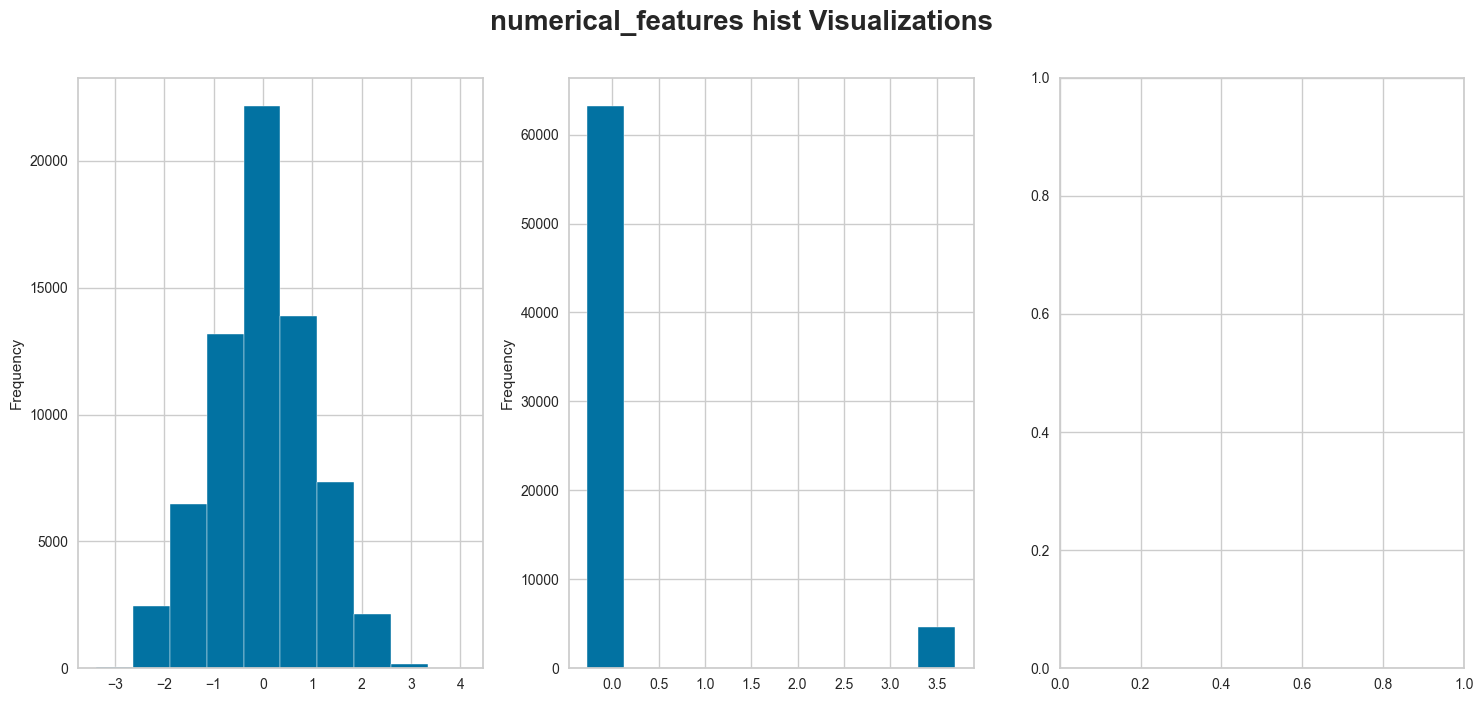

In [23]:
plot_numerical_features(x_copy[["veh_value","claimcst0"]],"hist")

---

In [24]:
for feature in categorical_features:
    print(feature,":",df[feature].unique())

veh_body : [ 9  3 10  4 12  2  7  1 11  8  0  5  6]
veh_age : [0 1 2 3]
gender : [0 1]
area : [0 1 2 3 4 5]
agecat : [0 1 2 3 4 5]


In [25]:
for feature in categorical_features:
    print(feature,":",df[feature].nunique())

veh_body : 13
veh_age : 4
gender : 2
area : 6
agecat : 6


---

*Apply ColumnTransformer to do all transdormation in once :*

In [26]:
from sklearn.preprocessing import PowerTransformer,StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [27]:
sc=StandardScaler()
onencood=OneHotEncoder()
ordinalencod=OrdinalEncoder()
transform_pipe=Pipeline(steps=[
    ("transformer",PowerTransformer(method="yeo-johnson"))
    ])

In [28]:
transform_features=['veh_value','claimcst0']
transform_features

['veh_value', 'claimcst0']

In [29]:
list_num_features=list(numerical_features.columns)
list_num_features

['veh_value', 'exposure', 'claimcst0']

In [30]:
preprocessor=ColumnTransformer([
    #("OneHotEncoder",onencood,on_columns),
    #("Ordinal_Encoder",ordinalencod,ordered_columns),
    ("transformer",transform_pipe,transform_features),
    ("StandardScaler",sc,list_num_features)
]
)

In [31]:
x=preprocessor.fit_transform(x)

---

*Hundling unbalanced data :*

In [32]:
from imblearn.combine import SMOTETomek,SMOTEENN
smt=SMOTEENN(random_state=42,sampling_strategy="minority")
x_re,y_res=smt.fit_resample(x,y)


---

*Split data into train and test subdata :*

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x_re,y_res ,test_size= 0.2,random_state=42)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (6812, 5) and Y = (6812,) : 
Test data shape of X = (1704, 5) and Y = (1704,) : 


---

*Define models :*

In [34]:
models = {
        
        "XGBRFClassifier": XGBRFClassifier(),
        "GradientBoostingClassifier":GradientBoostingClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        "LogisticRegression":LogisticRegression(),
        "SVC":SVC(),
        "KNeighborsClassifier":KNeighborsClassifier()
        
}

---

*Define evaluation funtion :*

In [35]:
def evaluation_preds_list(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    metrics_dict={
       "accuracy": round(accuracy,3),
          }
   
    return metrics_dict

In [36]:
def evaluation_preds(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    return accuracy

---

*Create one function to model the data :*

In [37]:
def evalua_models(x,y,models):
    x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20,random_state=42)
    models_list=[]
    accuracy_list=[]

    for i in  range(len(list(models))):
        model=list(models.values())[i]
        model.fit(x_train,y_train)

        train_predicted=model.predict(x_train)
        test_predicted=model.predict(x_test)      
        
        test_predicted_accuracy=evaluation_preds(y_test,test_predicted)
       
        accuracy_list.append(test_predicted_accuracy)

        print(list(models.keys())[i])
        
        models_list.append(list(models.keys())[i])
        
        print( test_predicted_accuracy)
        print("===========================")

    report=pd.DataFrame(list(zip(models_list,accuracy_list)),columns=["model","acc"]).sort_values(by="acc",ascending=False) 
    return report
  

---

*Apply Data Modeling*

In [38]:
evalua_models(x_re,y_res,models)

XGBRFClassifier
0.8444835680751174
GradientBoostingClassifier
0.8550469483568075
RandomForestClassifier
0.9231220657276995
AdaBoostClassifier
0.6185446009389671
DecisionTreeClassifier
0.9055164319248826
LogisticRegression
0.8262910798122066
SVC
0.8227699530516432
KNeighborsClassifier
0.8661971830985915


,model,acc
2,RandomForestClassifier,0.923122
4,DecisionTreeClassifier,0.905516
7,KNeighborsClassifier,0.866197
1,GradientBoostingClassifier,0.855047
0,XGBRFClassifier,0.844484
5,LogisticRegression,0.826291
6,SVC,0.822770
3,AdaBoostClassifier,0.618545


---

*Apply RandomForestClassifier :*

In [39]:
np.random.seed(42)
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)

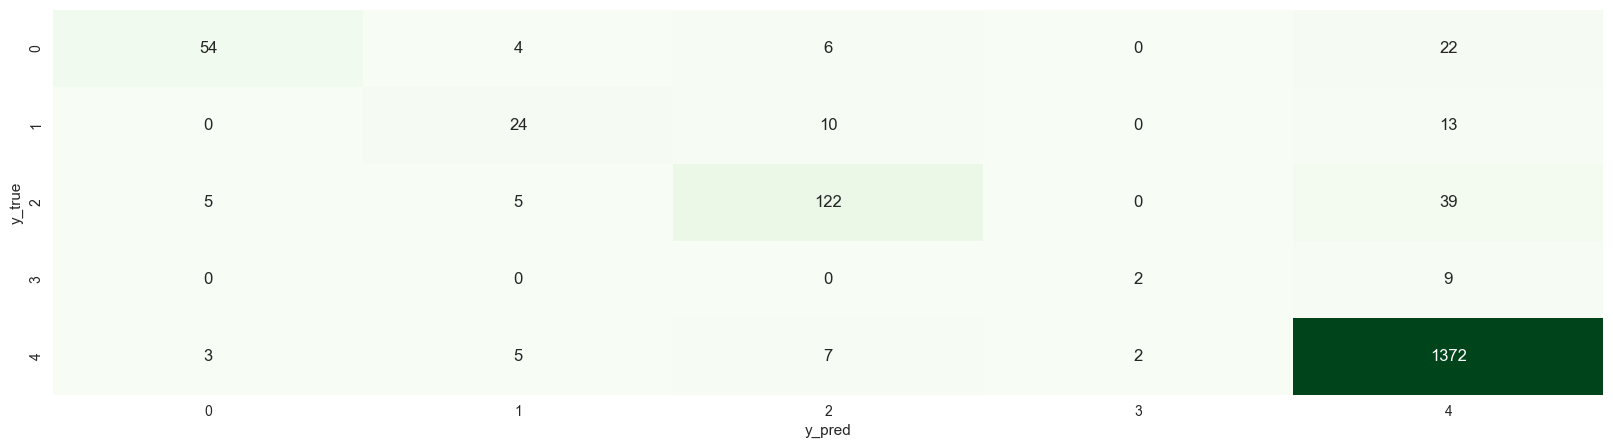

In [40]:
matplotlib.rcParams["figure.figsize"]=(20,5)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True,cmap="Greens", fmt = ".0f",cbar=False)
plt.xlabel("y_pred")
plt.ylabel("y_true");
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/confusionMatrixGraphs/area_confusion_matrixPlot.png',dpi=500);

In [41]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.87      0.63      0.73        86
           1       0.63      0.51      0.56        47
           2       0.84      0.71      0.77       171
           3       0.50      0.18      0.27        11
           5       0.94      0.99      0.96      1389

    accuracy                           0.92      1704
   macro avg       0.76      0.60      0.66      1704
weighted avg       0.92      0.92      0.92      1704



---

In [43]:
clf.feature_importances_.sum()

np.float64(1.0000000000000002)

In [42]:
clf.feature_names_in=list(df.drop("area",axis=1).columns)
importance=pd.concat([pd.DataFrame(clf.feature_names_in,columns=["feature_names"]),
           pd.DataFrame(clf.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.276827
1,exposure,0.011511
2,claimcst0,0.292314
3,veh_body,0.405875
4,veh_age,0.013473
5,gender,NaN
6,agecat,NaN


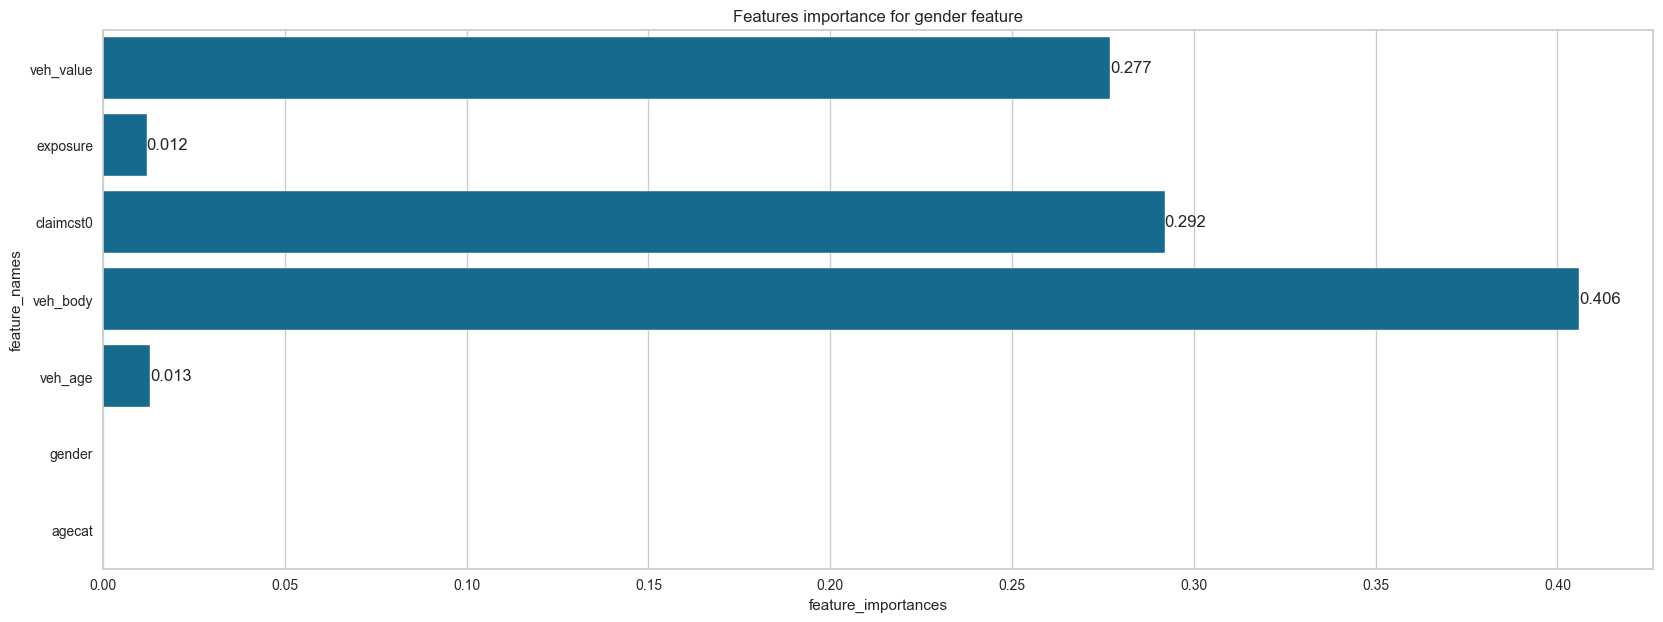

In [44]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for gender feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/area_featureImportanc.png',dpi=500);

*Saving Best model :*

In [45]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/area_prediction_model.pkl","wb") as f:
    pickle.dump(clf,f)

---